In [ ]:
%load_ext autoreload
%autoreload 2

### Import dependencies

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/fake-reviews-detection/source/common/')

In [ ]:
import data_preprocessing
import ngram
import linguistic_feature

### Import Data

In [ ]:
root_dir = "/content/drive/My Drive/Colab Notebooks/fake-reviews-detection"
df = data_preprocessing.import_raw_data(root_dir)
display(df[:5])

,Label,Rating,Ori_Review
0,1,1,The Fairmont Chicago Millennium Park has to be...
1,1,1,Me and my business associate had a job in Chic...
2,1,1,I stayed with my husband at the Homewood Suite...
3,1,1,My wife and I went to Chicago to enjoy our wee...
4,1,1,I recently stayed at the Hyatt Regency in Chic...


### Train-Test Split

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

### Preprocess & Feature Extraction

In [ ]:
df_train = data_preprocessing.preprocess_ngram(df_train)
df_test = data_preprocessing.preprocess_ngram(df_test)

In [ ]:
unigrams, bigrams, trigrams, unigrams_dict, bigrams_dict, trigrams_dict = ngram.find_universal_ngrams(df_train['PP_Review'])

In [ ]:
df_train['Ngram'] = df_train['Word_List'].apply(lambda x: ngram.find_ngrams(x, unigrams_dict, bigrams_dict, trigrams_dict))
df_test['Ngram'] = df_test['Word_List'].apply(lambda x: ngram.find_ngrams(x, unigrams_dict, bigrams_dict, trigrams_dict))
display(df_train[:3])
display(df_test[:3])

,Label,Rating,Ori_Review,Clean_Review,PP_Review,Word_List,Ngram
0,-1,1,I stayed in this hotel for a week and I was lo...,i stay in this hotel for a week and i be look ...,week look forward top class shock disapointed ...,"[week, look, forward, top, class, shock, disap...","[week, look, forward, top, class, broken, phon..."
1,1,1,Although the Millennium Knickerbocker Hotel Ch...,although the millennium knickerbocker hotel ch...,although millennium knickerbocker claim afford...,"[although, millennium, knickerbocker, claim, a...","[although, millennium, knickerbocker, claim, u..."
2,-1,1,After staying at the Sheraton Royal Orchid Hot...,after stay at the sheraton royal orchid hotel ...,sheraton royal orchid bangkok expect similar e...,"[sheraton, royal, orchid, bangkok, expect, sim...","[sheraton, expect, similar, experience, sherat..."


,Label,Rating,Ori_Review,Clean_Review,PP_Review,Word_List,Ngram
0,1,5,The Sheraton Chicago Hotel and Towers is my fa...,the sheraton chicago hotel and tower be my fav...,sheraton tower favorite place travel often vis...,"[sheraton, tower, favorite, place, travel, oft...","[sheraton, tower, favorite, place, travel, oft..."
1,1,1,The service was only subpar and then rooms nee...,the service be only subpar and then room need ...,service subpar need well clean check counter l...,"[service, subpar, need, well, clean, check, co...","[service, need, well, clean, check, counter, l..."
2,-1,5,"I am a fan of Kimpton Hotels, however I have n...",i be a fan of kimpton hotel however i have nev...,fan kimpton however never experience top servi...,"[fan, kimpton, however, never, experience, top...","[kimpton, however, never, experience, top, ser..."


In [ ]:
bigram_words = [' '.join(bigram) for bigram in bigrams]
trigram_words = [' '.join(trigram) for trigram in trigrams]
new_words = unigrams + bigram_words + trigram_words

In [ ]:
df_train = data_preprocessing.preprocess_linguistic_features(df_train)
df_train = linguistic_feature.linguistic_features(df_train)
df_test = data_preprocessing.preprocess_linguistic_features(df_test)
df_test = linguistic_feature.linguistic_features(df_test)

In [ ]:
word2ind = dict(zip(new_words, range(len(new_words))))

In [ ]:
X_train, y_train = data_preprocessing.df2matrix(df_train, word2ind)
X_test, y_test = data_preprocessing.df2matrix(df_test, word2ind)

In [ ]:
X_train_pos = X_train[X_train['Rating'] == 5]
y_train_pos = y_train[X_train['Rating'] == 5]
X_train_neg = X_train[X_train['Rating'] == 1]
y_train_neg = y_train[X_train['Rating'] == 1]

X_test_pos = X_test[X_test['Rating'] == 5]
y_test_pos = y_test[X_test['Rating'] == 5]
X_test_neg = X_test[X_test['Rating'] == 1]
y_test_neg = y_test[X_test['Rating'] == 1]

In [ ]:
X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

In [ ]:
X_train_pos_std = X_train_std[X_train['Rating'] == 5]
X_train_neg_std = X_train_std[X_train['Rating'] == 1]

X_test_pos_std = X_test_std[X_test['Rating'] == 5]
X_test_neg_std = X_test_std[X_test['Rating'] == 1]

### Train Model

#### 1) Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [ ]:
rf_model = RandomForestClassifier(criterion='gini', random_state=0)
parameters = {'n_estimators': [100, 500],
              'max_features': [5, 10, 20],
              'max_depth': [20, 50],
              'max_samples': [100, 500, None]}
grid_search = GridSearchCV(rf_model, param_grid=parameters, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)
print('Best Parameters: ', grid_search.best_params_)
print('Score', grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=100; total time=   0.2s
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=500; total time=   0.9s
[CV] END max_depth=20, max_features=5, max_samples=100, n_estimators=500; total time=   0.9s
[CV] END

In [ ]:
rf_model = RandomForestClassifier(random_state=0, 
                                  criterion='gini', 
                                  max_depth=20, 
                                  max_features=5, 
                                  max_samples=None, 
                                  n_estimators=500)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print('Random Forest Model Performance:')
print('- Test Accuracy: ', "{:.1%}".format(accuracy_score(y_test, y_pred)))
print('- Test Precision Score: ', "{:.1%}".format(precision_score(y_test, y_pred)))
print('- Test Recall Score: ', "{:.1%}".format(recall_score(y_test, y_pred)))
print('- Test F1 Score: ', "{:.1%}".format(f1_score(y_test, y_pred)))
print('- Test AUC-ROC Score: ', "{:.1%}".format(roc_auc_score(y_test, y_pred)))

Random Forest Model Performance:
- Test Accuracy:  85.6%
- Test Precision Score:  81.5%
- Test Recall Score:  91.0%
- Test F1 Score:  86.0%
- Test AUC-ROC Score:  85.8%


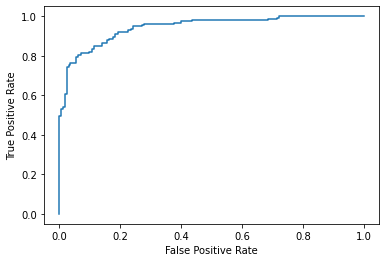

In [100]:
y_pred_prob = np.array(rf_model.predict_proba(X_test))[:,1]
y_test_labels = np.array(y_test)

fpr, tpr, _ = roc_curve(y_test_labels, y_pred_prob)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 2) PCA + SVM

In [103]:
pca = PCA()
svm_model = SVC()
pipeline = Pipeline(steps=[('pca', pca), ('svm', svm_model)])
parameters = {'svm__C': [3, 4], 'pca__n_components': list(range(1, 1001, 50))}
grid_search = GridSearchCV(pipeline, param_grid=parameters, cv=5, scoring='accuracy')
grid_search.fit(X_train_std, y_train)
print('Best Parameters: ', grid_search.best_params_)
print('Score', grid_search.best_score_)

Best Parameters:  {'pca__n_components': 151, 'svm__C': 3}
Score 0.8453125


In [104]:
pca = PCA(n_components=601)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
X_test_pos_pca = pca.transform(X_test_pos_std)
X_test_neg_pca = pca.transform(X_test_neg_std)

svm_model = SVC(C=3)
svm_model.fit(X_train_pca, y_train)
print('SVM Performance')
print('- Train Overall Accuracy: ', "{:.1%}".format(svm_model.score(X_train_pca, y_train)))
print('- Test Overall Accuracy: ', "{:.1%}".format(svm_model.score(X_test_pca, y_test)))
print('- Test Positive Accuracy: ', "{:.1%}".format(svm_model.score(X_test_pos_pca, y_test_pos)))
print('- Test Negative Accuracy: ', "{:.1%}".format(svm_model.score(X_test_neg_pca, y_test_neg)))

SVM Performance
- Train Overall Accuracy:  99.5%
- Test Overall Accuracy:  85.0%
- Test Positive Accuracy:  86.0%
- Test Negative Accuracy:  84.0%


In [106]:
y_pred_test = svm_model.predict(X_test_pca)

print('SVM Model Test Data Performance')
print('- Test Accuracy: ', "{:.1%}".format(accuracy_score(y_test, y_pred_test)))
print('- Test Precision Score: ', "{:.1%}".format(precision_score(y_test, y_pred_test)))
print('- Test Recall Score: ', "{:.1%}".format(recall_score(y_test, y_pred_test)))
print('- Test F1 Score: ', "{:.1%}".format(f1_score(y_test, y_pred_test,)))
print('- Test AUC-ROC Score: ', "{:.1%}".format(roc_auc_score(y_test, y_pred_test)))

SVM Model Test Data Performance
- Test Accuracy:  85.0%
- Test Precision Score:  82.4%
- Test Recall Score:  87.7%
- Test F1 Score:  85.0%
- Test AUC-ROC Score:  85.1%


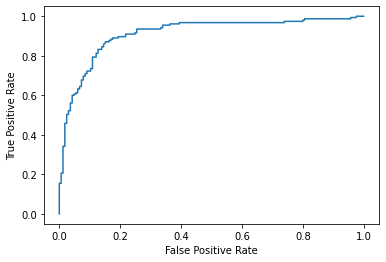

In [108]:
svm_model_prob = SVC(C=3, gamma='auto', probability=True)
svm_model_prob.fit(X_train_pca, y_train)

y_pred_prob = np.array(svm_model_prob.predict_proba(X_test_pca))[:,1]
y_test_labels = np.array(y_test)

fpr, tpr, _ = roc_curve(y_test_labels, y_pred_prob)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()